# **Libraries & Connection to Drive**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter, defaultdict
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
!pip install shap
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 77, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_

In [ ]:
# Connection to Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Assign each data set to a table**

In [ ]:
company_data = pd.read_excel('/content/drive/MyDrive/Applied Data Science Research Project/Colab Code/Data_modified.xlsx', sheet_name='01.COMPANY')
investment_data = pd.read_excel('/content/drive/MyDrive/Applied Data Science Research Project/Colab Code/Data_modified.xlsx', sheet_name='02.INVESTMENT')
acquisition_data = pd.read_excel('/content/drive/MyDrive/Applied Data Science Research Project/Colab Code/Data_modified.xlsx', sheet_name='03.ACQUISITION')
employee_data = pd.read_excel('/content/drive/MyDrive/Applied Data Science Research Project/Colab Code/Data_modified.xlsx', sheet_name='04.EMPLOYEE')
news_data_classification = pd.read_excel('/content/drive/MyDrive/Applied Data Science Research Project/Colab Code/Data_modified.xlsx', sheet_name='News with classification')


# **COMPANY CLEANING**

**CATEGORIES**

In [ ]:
# Divide column 'CATEGORY' in many columns
categories_expanded = company_data['CATEGORY'].str.split(', ', expand=True)

# Rename new columns
categories_expanded.columns = [f'category {i+1}' for i in range(categories_expanded.shape[1])]

# Drop original 'CATEGORY' column
company_data.drop('CATEGORY', axis=1, inplace=True)

# Concat original DataFrame (without column 'CATEGORY') with new categories data frame
company_data = pd.concat([company_data, categories_expanded], axis=1)

print(company_data)

            COMPANY_ID      COMPANY_NAME  \
0                drift             Drift   
1               skillz            Skillz   
2               upgrad            UpGrad   
3            oculus-vr            Oculus   
4             outreach          Outreach   
...                ...               ...   
9966           homecon           HomeCon   
9967             jiuge             Jiuge   
9968  shipping-company  Shipping Company   
9969    grizzly-boards    Grizzly Boards   
9970        wiotti-llc        Wiotti LLC   

                                      LOCATION    FOUNDED_ON     EXITED_ON  \
0         Boston, Massachusetts, United States          2015             —   
1     San Francisco, California, United States   Apr 1, 2012  Dec 17, 2020   
2                   Mumbai, Maharashtra, India      Mar 2015             —   
3        Menlo Park, California, United States   Jul 6, 2012  Mar 25, 2014   
4           Seattle, Washington, United States          2011             —   
...

**LOCATIONS**

In [ ]:
# Divide column 'LOCATION' en 4 segments, as some rows have 4 segments
location_components = company_data['LOCATION'].str.split(', ', expand=True)

# When there are 4 segments, there is an additional segment that can be ignored
company_data['city'] = location_components[0]
company_data['state'] = location_components[1]

# 'country'assignation depends if there is a forth segment (which  would indicate a country)
company_data['country'] = location_components[3].where(location_components[3].notnull(), location_components[2])

# Print result to verify
print(company_data[['COMPANY_NAME', 'city', 'state', 'country']])

          COMPANY_NAME           city          state        country
0                Drift         Boston  Massachusetts  United States
1               Skillz  San Francisco     California  United States
2               UpGrad         Mumbai    Maharashtra          India
3               Oculus     Menlo Park     California  United States
4             Outreach        Seattle     Washington  United States
...                ...            ...            ...            ...
9966           HomeCon        Toronto        Ontario         Canada
9967             Jiuge              —           None           None
9968  Shipping Company         Pueblo       Colorado  United States
9969    Grizzly Boards          Aspen       Colorado  United States
9970        Wiotti LLC         Austin          Texas  United States

[9971 rows x 4 columns]


In [ ]:
# Manage special case of Democratic Republic of Congo
company_data['country'] = company_data.apply(lambda row: "Democratic Republic of Congo" if "Democratic Republic of" in (row['country'] or "") else row['country'], axis=1)



**FECHAS**

In [ ]:
# Transform dates in years to be the first day of that year
def convert_year_first_day(series):
    # Convert values that appear to be just a year to 'yyyy-01-01'
    series = series.apply(lambda x: f"{x}-01-01" if (isinstance(x, int) or (isinstance(x, str) and x.isdigit())) else x)
    # Now try to convert all entries to datetime
    return pd.to_datetime(series, errors='coerce')

# Apply the function to each relevant column
company_data['FOUNDED_ON'] = convert_year_first_day(company_data['FOUNDED_ON'])
company_data['EXITED_ON'] = convert_year_first_day(company_data['EXITED_ON'])
company_data['CLOSED_ON'] = convert_year_first_day(company_data['CLOSED_ON'])


# Show some conversions to verify
print(company_data[['FOUNDED_ON', 'EXITED_ON', 'CLOSED_ON']].head())

  FOUNDED_ON  EXITED_ON CLOSED_ON
0 2015-01-01        NaT       NaT
1 2012-04-01 2020-12-17       NaT
2 2015-03-01        NaT       NaT
3 2012-07-06 2014-03-25       NaT
4 2011-01-01        NaT       NaT


**CHECK RESULTS**

In [ ]:
file_path = '/content/drive/My Drive/company_.xlsx'

# Export Data Frame
company_data.to_excel(file_path, index=False)

# **INVESTMENT CLEANING**

**Date**

In [ ]:
# Convert date columns to datetime format
investment_data['ANNOUNCED_DATE'] = pd.to_datetime(investment_data['ANNOUNCED_DATE'])

**Create "ADVANCED_STAGE" field to determine if a company reached an advanced investment round**

In [ ]:
investment_data['ADVANCED_STAGE'] = investment_data['INVESTMENT_STAGE'].apply(lambda x: 'No' if x == 'Seed' else 'Yes')


In [ ]:
# Function to determine the preferred row in case of multiple entries
def elegir_fila_grupo(grupo):
    if 'Yes' in grupo['ADVANCED_STAGE'].values:
        grupo_filtrado = grupo[grupo['ADVANCED_STAGE'] == 'Yes']
    else:
        grupo_filtrado = grupo  # If all are 'No', keep the group as is

    # Select the row with the earliest date
    return grupo_filtrado.sort_values(by='ANNOUNCED_DATE').iloc[0]

# Group by COMPANY_ID and apply the function to select the desired row
investment_data = investment_data.groupby('COMPANY_ID').apply(elegir_fila_grupo).reset_index(drop=True)

# Print Result
print(investment_data)

                  COMPANY_ID              FUNDING_TYPE ANNOUNCED_DATE  \
0                 %C3%81eron                  Series A     2014-08-01   
1                 %C4%93dn-2          Convertible Note     2016-02-26   
2      -the-one-of-them-inc-                  Series A     2011-10-03   
3                     1-page                      Seed     2012-04-01   
4                    10alike                      Seed     2013-01-01   
...                      ...                       ...            ...   
8643                 zybooks  Venture - Series Unknown     2013-12-01   
8644  zylox-tongqiao-medical                  Series A     2015-11-05   
8645                 zynstra                  Series A     2013-09-12   
8646                    zype                  Series A     2017-10-13   
8647                   zzish       Equity Crowdfunding     2017-05-26   

         INVESTMENT_STAGE   MONEY_RAISED ADVANCED_STAGE  
0     Early Stage Venture              —            Yes  
1      

In [ ]:
# Create a list of unique COMPANY_IDs from the second table (investment_data)
company_ids_con_inversion = investment_data['COMPANY_ID'].unique().tolist()

# Mark with "Yes" all companies that had investment, with "No" those that never had
def determinar_avance(row):
    if row['COMPANY_ID'] in company_ids_con_inversion:
        return "Yes"
    else:
        return "No"

# Apply the function to the companies DataFrame to create the new column
company_data['ADVANCED_STAGE'] = company_data.apply(determinar_avance, axis=1)

In [ ]:
file_path = '/content/drive/My Drive/investment_data.xlsx'

# Export Data Frame
investment_data.to_excel(file_path, index=False)

# **ACQUISITION CLEANING**

In [ ]:
# Convert the 'ANNOUNCED_DATE' column from string to datetime to correctly sort the dates
investment_data['ANNOUNCED_DATE'] = pd.to_datetime(investment_data['ANNOUNCED_DATE'], errors='coerce')

# Filter to exclude entries where INVESTMENT_STAGE is "Seed"
filtered_datas = investment_data[investment_data['INVESTMENT_STAGE'] != 'Seed']

# Sort the filtered DataFrame by 'COMPANY_ID' and 'ANNOUNCED_DATE' (ascending)
sorted_filtered_datas = filtered_datas.sort_values(by=['COMPANY_ID', 'ANNOUNCED_DATE'])

# Keep only the oldest row for each 'COMPANY_ID'
unique_company_rowz = sorted_filtered_datas.drop_duplicates(subset='COMPANY_ID', keep='first')

# Print Result
print(unique_company_rowz)

                  COMPANY_ID              FUNDING_TYPE ANNOUNCED_DATE  \
0                 %C3%81eron                  Series A     2014-08-01   
1                 %C4%93dn-2          Convertible Note     2016-02-26   
2      -the-one-of-them-inc-                  Series A     2011-10-03   
9                     17hats  Venture - Series Unknown     2015-10-01   
10                 18birdies  Venture - Series Unknown     2017-12-07   
...                      ...                       ...            ...   
8643                 zybooks  Venture - Series Unknown     2013-12-01   
8644  zylox-tongqiao-medical                  Series A     2015-11-05   
8645                 zynstra                  Series A     2013-09-12   
8646                    zype                  Series A     2017-10-13   
8647                   zzish       Equity Crowdfunding     2017-05-26   

         INVESTMENT_STAGE   MONEY_RAISED ADVANCED_STAGE  
0     Early Stage Venture              —            Yes  
1      

In [ ]:
# Join Data to compare acquisitions previous to reaching an investment round
joined_data = pd.merge(
    acquisition_data[['ACQUIRER_ID', 'ANNOUNCED_DATE']],
    unique_company_rowz[['COMPANY_ID', 'ANNOUNCED_DATE', 'INVESTMENT_STAGE']],
    left_on='ACQUIRER_ID',
    right_on='COMPANY_ID',
    how='right',
    suffixes=('_ACQUISITION', '_INVESTMENT')
)


In [ ]:
# Ensure the ANNOUNCED_DATE_ACQUISITION and ANNOUNCED_DATE_INVESTMENT columns are in datetime format
joined_data['ANNOUNCED_DATE_ACQUISITION'] = pd.to_datetime(joined_data['ANNOUNCED_DATE_ACQUISITION'])
joined_data['ANNOUNCED_DATE_INVESTMENT'] = pd.to_datetime(joined_data['ANNOUNCED_DATE_INVESTMENT'])

# Filter the DataFrame where ANNOUNCED_DATE_ACQUISITION is before ANNOUNCED_DATE_INVESTMENT
filtered_data = joined_data[joined_data['ANNOUNCED_DATE_ACQUISITION'] < joined_data['ANNOUNCED_DATE_INVESTMENT']]

# Display unique ACQUIRER_IDs from the filtered data
unique_acquirer_ids = filtered_data['ACQUIRER_ID'].unique()
print(unique_acquirer_ids)

['adavium' 'amryt-pharma' 'and-global' 'anthem-vault' 'arria-nlg'
 'aspire-food-group' 'auticon' 'avalon-globocare' 'backtowork24' 'badakan'
 'bimobject' 'blavity' 'blippar' 'boatsetter' 'bracket' 'brandzooka'
 'brigade' 'bsd-code-and-design-academy' 'cazana' 'charge-payment'
 'circle-ci' 'civicsmart-inc' 'cleardata' 'click-therapeutics' 'coding-2'
 'cordata-healthcare-innovations' 'creativedrive' 'crown-electrokinetics'
 'customermatrix' 'cylance' 'dagoma' 'dah-makan' 'dash-living'
 'dash-robotics' 'drinks' 'el-grocer' 'enthusiast-gaming-inc'
 'evolent-health' 'factory-2' 'fave-59ea' 'fexy-media-llc' 'flaviar'
 'gfinity' 'ginger-io' 'gogolook' 'gradtouch' 'happy-tax' 'harrys'
 'headspin-inc' 'hem' 'hls-therapeutics' 'hobbydb' 'huckberry'
 'hungry-harvest' 'i-am-plus-electronics' 'inner-chef' 'inventergy'
 'invesdor-oy' 'jetsynthesys' 'kili' 'le-sports' 'leafbuyer' 'lendified'
 'liberty-oilfield-services' 'maestro-healthcare-technology' 'makeena'
 'membersy' 'mercadoni' 'miora' 'mitre-

In [ ]:
number_of_unique_acquirers = len(unique_acquirer_ids)
print(number_of_unique_acquirers)

# As there are 136 companies that made an acquisition before reaching a late stage investment, this analysis would not contribute the model. 136/9971 = 1.4%

136


# **EMPLOYEE CLEANING**

In [ ]:
Top20_Universities = [
    "University of Oxford",
    "Oxford University",
    "MIT",
    "Stanford University",
    "Stanford Graduate School of Business",
    "Stanford",
    "Massachusetts Institute of Technology (MIT)",
    "Massachusetts Institute of Technology - MIT",
    "MIT",
    "Harvard University",
    "Harvard",
    "Cambridge College",
    "University of Cambridge",
    "Princeton University",
    "Caltech",
    "California Institute of Technology",
    "California Institute of Technology (Caltech)",
    "Imperial College London",
    "University of California, Berkeley",
    "University of California, Berkeley (UCB)",
    "UC Berkeley",
    "Yale University",
    "Yale",
    "ETH Zurich",
    "Tsinghua University",
    "Tsing Hua",
    "The University of Chicago",
    "University of Chicago",
    "Peking University",
    "Johns Hopkins University",
    "Johns Hopkins",
    "University of Pennsylvania",
    "Columbia University",
    "Columbia Business School",
    "University of California, Los Angeles (UCLA)",
    "UCLA",
    "University of California",
    "National University of Singapore (NUS)",
    "National University of Singapore",
    "Cornell University"
]

#Preprocessing the list of universities to ignore uppercase and spaces
Top20_Universities = [university.lower().replace(" ", "") for university in Top20_Universities]

# Initialize a new column in the DataFrame to indicate the presence of a Top 20 University
employee_data['Top20_University_Present'] = 'No'

# Function to check for the presence of any university from the list in the ATTENDED_SCHOOLS column
def check_top20_university(row):
    attended_schools = str(row['ATTENDED_SCHOOLS']).lower().replace(" ", "")
    for university in Top20_Universities:
        if university in attended_schools:  # Case-insensitive and spaceless search
            return 'Yes'
    return 'No'

# Apply the function to each row
employee_data['Top20_University_Present'] = employee_data.apply(check_top20_university, axis=1)

# Show the first rows of the DataFrame to verify the result
print(employee_data[['ATTENDED_SCHOOLS', 'Top20_University_Present']].head())

                                    ATTENDED_SCHOOLS Top20_University_Present
0          Harvard University Singularity University                      Yes
1   Massachusetts Institute of Technology - MIT R...                      Yes
2                                                NaN                       No
3                                                NaN                       No
4             Indian Institute of Technology Roorkee                       No


In [ ]:
# Split the 'COMPANY_IDS' column by commas and then use explode to expand the resulting lists into rows
employee_data['COMPANY_IDS'] = employee_data['COMPANY_IDS'].str.split(',')
employee_data = employee_data.explode('COMPANY_IDS')

# Reset the index of the resulting DataFrame to clean up the index after explode
employee_data.reset_index(drop=True, inplace=True)

# Rename Column
employee_data.rename(columns={'COMPANY_IDS': 'COMPANY_ID'}, inplace=True)


# **NEWS DATA CLASSIFICATION CLEANING**

In [ ]:
news_data_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11918 entries, 0 to 11917
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   COMPANY_ID     11918 non-null  object
 1   NEWS_DATE      11918 non-null  object
 2   NEWS_VENUE     11446 non-null  object
 3   NEWS_TITLE     11918 non-null  object
 4   COMPANY_NAME   11918 non-null  object
 5   CATEGORY       11918 non-null  object
 6   LOCATION       11918 non-null  object
 7   FOUNDED_ON     11918 non-null  object
 8   EXITED_ON      11918 non-null  object
 9   CLOSED_ON      11918 non-null  object
 10  Clasificacion  11918 non-null  object
dtypes: object(11)
memory usage: 1.0+ MB


In [ ]:
# Change Format to DateTime
news_data_classification['NEWS_DATE'] = pd.to_datetime(news_data_classification['NEWS_DATE'], errors='coerce')

# Show some of the conversions to verify
print(news_data_classification[['NEWS_DATE']].head())

   NEWS_DATE
0 2020-02-24
1 2018-04-08
2 2017-01-24
3 2014-08-06
4 2019-11-05


In [ ]:
news_data_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11918 entries, 0 to 11917
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   COMPANY_ID     11918 non-null  object        
 1   NEWS_DATE      11918 non-null  datetime64[ns]
 2   NEWS_VENUE     11446 non-null  object        
 3   NEWS_TITLE     11918 non-null  object        
 4   COMPANY_NAME   11918 non-null  object        
 5   CATEGORY       11918 non-null  object        
 6   LOCATION       11918 non-null  object        
 7   FOUNDED_ON     11918 non-null  object        
 8   EXITED_ON      11918 non-null  object        
 9   CLOSED_ON      11918 non-null  object        
 10  Clasificacion  11918 non-null  object        
dtypes: datetime64[ns](1), object(10)
memory usage: 1.0+ MB


In [ ]:
# Drop unnecessary columns
news_data_classification = news_data_classification.drop(columns=['COMPANY_NAME', 'CATEGORY', 'LOCATION', 'FOUNDED_ON', 'EXITED_ON', 'CLOSED_ON'])

# Show the first rows of the resulting DataFrame to verify
print(news_data_classification.head())

          COMPANY_ID  NEWS_DATE              NEWS_VENUE  \
0               down 2020-02-24                News BTC   
1             cheers 2018-04-08  Times Of India | Blogs   
2  illusive-networks 2017-01-24              TechCrunch   
3          clear-ear 2014-08-06              TechCrunch   
4             rtsafe 2019-11-05            newswire.com   

                                          NEWS_TITLE Clasificacion  
0  Ripple (XRP) Price Wonât Go Down Quietly: Ke...      negative  
1                   Cheers! Another World Health Day       neutral  
2  Microsoft Ventures backs Illusive Networks, a ...       neutral  
3  Clear Earâs Products Are Safe Alternatives T...       neutral  
4  RTsafe Wins Prestigious 2019 R&D 100 Awards Fr...      positive  


# **FINAL DATASET**

In [ ]:
def contar_noticias(row, news_data_classification):
    # Filter news by COMPANY_ID and by date before ANNOUNCED_DATE
    noticias_previas = news_data_classification[(news_data_classification['COMPANY_ID'] == row['COMPANY_ID']) & (news_data_classification['NEWS_DATE'] < row['ANNOUNCED_DATE'])]

    # Count classifications
    conteo = noticias_previas['Clasificacion'].value_counts().to_dict()

    # Return count for each classification, 0 if there are no news
    row['Positive'] = conteo.get('positive', 0)
    row['Negative'] = conteo.get('negative', 0)
    row['Neutral'] = conteo.get('neutral', 0)

    return row

# Apply the function to each row in the investment DataFrame
df_investment_news = investment_data.apply(lambda row: contar_noticias(row, news_data_classification), axis=1)

In [ ]:
# Filter companies that didn't receive investment
company_no_investment = company_data[company_data['ADVANCED_STAGE'] == 'No']



In [ ]:
# Change Data Type to integer
news_data_classification['Positive'] = (news_data_classification['Clasificacion'] == 'positive').astype(int)
news_data_classification['Negative'] = (news_data_classification['Clasificacion'] == 'negative').astype(int)
news_data_classification['Neutral'] = (news_data_classification['Clasificacion'] == 'neutral').astype(int)

# Group by COMPANY_ID and sum
df_news_counts = news_data_classification.groupby('COMPANY_ID', as_index=False).agg({
    'Positive': 'sum',
    'Negative': 'sum',
    'Neutral': 'sum'
})

# Step 2: Merge df_company with df_news_counts
# Merge (left join) df_company with df_news_counts on 'COMPANY_ID'
company_no_investment_news = pd.merge(company_no_investment, df_news_counts, on='COMPANY_ID', how='left')

# Fill NaNs with 0s for the 'Positive', 'Negative', 'Neutral' columns after the merge
company_no_investment_news[['Positive', 'Negative', 'Neutral']] = company_no_investment_news[['Positive', 'Negative', 'Neutral']].fillna(0).astype(int)

In [ ]:
# Merge Investment and Company data sets
df_merged = pd.merge(df_investment_news, company_data, on='COMPANY_ID', how='inner')


In [ ]:
# Drop the column 'ADVANCED_STAGE_y'
df_merged =  df_merged.drop(columns=['ADVANCED_STAGE_y'])

# Rename 'ADVANCED_STAGE_x' to 'ADVANCED
df_merged = df_merged.rename(columns={'ADVANCED_STAGE_x': 'ADVANCED_STAGE'})

In [ ]:
# Build Final DF by concat the companies that received Investment with their classification and the ones that didn't
final_df = pd.concat([df_merged, company_no_investment_news], ignore_index=True)


In [ ]:
# Drop specified columns from final_df
final_df = final_df.drop(columns=['FUNDING_TYPE', 'ANNOUNCED_DATE', 'INVESTMENT_STAGE','FOUNDED_ON', 'EXITED_ON', 'CLOSED_ON'])

# Show DataFrame
print(final_df)

                 COMPANY_ID  MONEY_RAISED ADVANCED_STAGE  Positive  Negative  \
0                %C3%81eron             —            Yes         0         0   
1                %C4%93dn-2      $100,000            Yes         0         0   
2     -the-one-of-them-inc-  ¥300,000,000            Yes         0         0   
3                    1-page    $1,500,000             No         0         0   
4                   10alike             —             No         0         0   
...                     ...           ...            ...       ...       ...   
9966               playmobs           NaN             No         0         0   
9967            identimob-2           NaN             No         0         0   
9968    envision-blue-green           NaN             No         0         0   
9969                  jiuge           NaN             No         0         0   
9970       shipping-company           NaN             No         0         0   

      Neutral         COMPANY_NAME     

In [ ]:
# Join Final DF with Employees data
final_df = pd.merge(final_df, employee_data, on='COMPANY_ID', how='left')

In [ ]:
# Drop the 'JOB_TITLES' and 'ATTENDED_SCHOOLS' columns from final_df
final_df = final_df.drop(['JOB_TITLES', 'ATTENDED_SCHOOLS'], axis=1)

# Fill blank/missing values in 'Top20_University_Present' with 'No'
final_df['Top20_University_Present'] = final_df['Top20_University_Present'].fillna('No')


In [ ]:
# Keep only an unique row, as the join repetead rows
final_df = final_df.drop_duplicates(subset='COMPANY_ID', keep='first')


In [ ]:
# Define broader industry categories
industries = {
    "Technology": ["3D Printing", "3D Technology", "A/B Testing", "Ad Exchange", "Ad Network", "Ad Retargeting", "Ad Server",
    "Ad Targeting", "Advanced Materials", "Analytics", "Android", "Angel Investment", "App Discovery",
    "App Marketing", "Application Performance Management", "Application Specific Integrated Circuit (ASIC)", "Apps",
    "Artificial Intelligence", "Augmented Reality", "Auto Insurance", "Automotive", "Autonomous Vehicles", "B2B",
    "B2C", "Battery", "Big Data", "Billing", "Bioinformatics", "Blockchain", "Blogging Platforms", "Browser Extensions",
    "Business Information Systems", "Business Intelligence", "CAD", "Call Center", "Cloud Computing", "Cloud Data Services","Cloud Infrastructure", "Cloud Management", "Cloud Security", "Cloud Storage", "CMS",
    "Collaboration", "Collaborative Consumption", "Communication Hardware", "Communications Infrastructure",
    "Computer", "Computer Vision", "Content", "Content Creators", "Content Delivery Network",
    "Content Discovery", "Content Marketing", "Content Syndication", "CRM", "Crowdfunding",
    "Crowdsourcing", "Cryptocurrency", "Cyber Security", "Data Center", "Data Center Automation",
    "Data Integration", "Data Mining", "Data Storage", "Data Visualization", "Database",
    "Developer APIs", "Developer Platform", "Developer Tools", "Digital Entertainment",
    "Digital Marketing", "Digital Media", "Digital Signage", "Direct Marketing", "Direct Sales",
    "Document Management", "Document Preparation", "Domain Registrar", "DRM", "Drone Management",
    "Drones", "DSP", "E-Commerce", "E-Commerce Platforms", "E-Learning", "E-Signature",
    "EBooks", "Ediscovery", "Electric Vehicle", "Electrical Distribution", "Electronic Design Automation (EDA)", "Electronic Health Record (EHR)",
    "Electronics", "Email", "Email Marketing", "Embedded Software", "Embedded Systems", "Emergency Medicine",
    "Emerging Markets", "Energy Efficiency", "Energy Management", "Energy Storage", "Enterprise", "Enterprise Applications",
    "Enterprise Resource Planning (ERP)", "Enterprise Software", "Environmental Consulting", "Environmental Engineering",
    "eSports", "Ethereum", "Event Management", "Event Promotion", "Events", "Eyewear", "Facebook", "Facial Recognition",
    "Facilities Support Services", "Facility Management", "Fantasy Sports", "Field Support", "Field-Programmable Gate Array (FPGA)",
    "File Sharing", "Film", "Film Distribution", "Film Production", "Flash Storage", "Fleet Management", "Fraud Detection",
    "Freelance", "Freemium", "Freight Service", "Fuel Cell", "Funding Platform", "Gambling", "Gamification", "Gaming",
    "Generation Z", "Genetics", "Geospatial", "Google", "Google Glass", "Government", "GovTech", "GPS", "GPU", "Graphic Design",
    "Green Building", "Green Consumer Goods", "GreenTech", "Grocery", "Group Buying", "Guides", "Handmade", "Hardware","Human Computer Interaction", "IaaS", "Identity Management", "Image Recognition",
    "Indoor Positioning", "Information and Communications Technology (ICT)", "Information Services",
    "Information Technology", "Infrastructure", "Innovation Management", "InsurTech", "Intelligent Systems",
    "Internet", "Internet of Things", "Internet Radio", "Intrusion Detection", "iOS", "ISP",
    "IT Infrastructure", "IT Management", "Machine Learning", "Management Information Systems","Messaging", "mHealth", "Mobile", "Mobile Advertising", "Mobile Apps", "Mobile Devices", "Mobile Payments",
    "MOOC", "Motion Capture", "Music Streaming", "Nanotechnology", "Natural Language Processing", "Navigation",
    "Network Hardware", "Network Security", "Neuroscience", "NFC", "Online Auctions", "Online Forums", "Online Games",
    "Online Portals", "Open Source", "Operating Systems", "Optical Communication", "Outsourcing", "PaaS",
    "Penetration Testing", "Personalization", "Photo Editing", "Photo Sharing", "Photography", "Physical Security",
    "Podcast", "Point of Sale", "Pollution Control", "Power Grid", "Predictive Analytics", "Presentation Software",
    "Privacy", "Private Cloud", "Private Social Networking", "Product Design", "Product Management","Product Search", "Productivity Tools", "Professional Networking", "Project Management",
    "Property Management", "Public Relations", "Public Safety", "Public Transportation", "Publishing", "Q&A",
    "QR Codes", "Quality Assurance", "Quantified Self", "Quantum Computing", "Reading Apps", "Real Time",
    "Recruiting", "Recycling", "Renewable Energy", "Reservation", "RFID", "Ride Sharing", "Risk Management",
    "Robotics", "SaaS", "Sales", "Sales Automation", "Same Day Delivery", "Satellite Communication",
    "Scheduling", "Search Engine", "Security", "Self-Storage", "SEM", "Semantic Search", "Semantic Web",
    "Semiconductor", "Sensor", "SEO", "Service Industry", "Sharing Economy", "Shipping", "Shipping Broker",
    "Shopping", "Shopping Mall", "Simulation", "Skill Assessment", "Smart Building", "Smart Cities",
    "Smart Home", "SMS", "Social", "Social Bookmarking", "Social CRM", "Social Entrepreneurship",
    "Social Impact", "Social Media", "Social Media Advertising", "Social Media Management", "Social Media Marketing",
    "Social Network", "Social News", "Social Recruiting", "Social Shopping", "Software", "Software Engineering","Solar", "Space Travel", "Speech Recognition", "Subscription Service", "Supply Chain Management",
    "Task Management", "Technical Support", "Telecommunications", "Test and Measurement", "Text Analytics",
    "Ticketing", "Translation Service", "Transportation", "Travel Accommodations", "Travel Agency", "Tutoring",
    "TV", "TV Production", "Unified Communications", "UX Design", "Vacation Rental", "Venture Capital",
    "Vertical Search", "Video", "Video Advertising", "Video Chat", "Video Conferencing", "Video Editing",
    "Video Games", "Video on Demand", "Video Streaming", "Virtual Assistant", "Virtual Currency",
    "Virtual Desktop", "Virtual Goods", "Virtual Reality", "Virtual Workforce", "Virtual World", "Virtualization",
    "Visual Search", "VoIP", "Warehousing", "Waste Management", "Water Purification", "Web Apps",
    "Web Browsers", "Web Design", "Web Development", "Web Hosting"],

    "Health & Wellness": ["Alternative Medicine", "Assisted Living", "Assistive Technology", "Biopharma", "Biotechnology", "Clinical Trials","Cosmetic Surgery", "Cosmetics", "Dental", "Dietary Supplements", "Diabetes","Elder Care", "Elderly", "Emergency Medicine", "Fertility","Health Care", "Health Diagnostics", "Health Insurance", "Home Health Care", "Horticulture",
    "Hospital", "Humanitarian", "Medical", "Medical Device", "mHealth", "Military", "Mineral", "Nutrition", "Nursing and Residential Care",
    "Nutrition", "Outpatient Care", "Personal Health", "Pharmaceutical","Psychology", "Rehabilitation","Wellness", "Therapeutics"],

    "Finance": ["Accounting", "Angel Investment", "Asset Management", "Banking", "Bitcoin","Credit", "Credit Bureau", "Credit Cards", "Commercial Insurance", "Commercial Lending",  "Finance", "Financial Exchanges", "Financial Services", "FinTech","Micro Lending", "Mobile Payments", "Personal Finance", "Prediction Markets","Property Insurance", "Real Estate", "Real Estate Investment", "Retail","Stock Exchanges", "Wealth Management"],

    "Education": ["E-Learning", "Continuing Education", "Corporate Training", "E-Learning", "Ediscovery","EdTech", "Education", "Edutainment", "Higher Education", "Language Learning","Meeting Software", "Men's", "MOOC", "Music Education", "Primary Education","Professional Services", "Secondary Education","STEM Education", "Universities", "Vocational Education"],

    "Manufacturing": ["Advanced Materials", "Aerospace", "Agriculture", "AgTech", "Automotive", "Battery", "Biotechnology",
    "Chemical", "Chemical Engineering", "Civil Engineering", "Clean Energy", "CleanTech","Food Processing", "Forestry", "Fossil Fuels", "Furniture","Industrial", "Industrial Automation", "Industrial Design", "Industrial Engineering",
    "Industrial Manufacturing", "Machinery Manufacturing", "Manufacturing","Mechanical Engineering", "Medical Device", "Mining", "Mining Technology", "Mobile Devices", "Musical Instruments",
    "Plastics and Rubber Manufacturing","Textiles", "Toys","Energy"],

    "Miscellaneous": ["Adult", "Adventure Travel", "Advertising", "Advertising Platforms", "Advice", "Air Transportation", "Alumni",
    "American Football", "Animal Feed", "Animation", "Aquaculture", "Architecture", "Art", "Association", "Auctions",
    "Audio", "Baby", "Bakery", "Basketball", "Beauty", "Biofuel", "Biomass Energy", "Biometrics", "Boating",
    "Brand Marketing", "Brewing", "Broadcasting", "Building Maintenance", "Building Material", "Business Development",
    "Business Travel", "Cannabis", "Car Sharing", "Career Planning", "Casino", "Casual Games", "Catering",
    "Cause Marketing", "Celebrity", "Charity", "Child Care", "Children", "CivicTech", "Classifieds","Coffee", "Collectibles", "College Recruiting", "Commercial", "Commercial Real Estate",
    "Communities", "Compliance", "Concerts", "Confectionery", "Console Games", "Construction",
    "Consulting", "Consumer", "Consumer Applications", "Consumer Electronics", "Consumer Goods",
    "Consumer Lending", "Consumer Research", "Consumer Reviews", "Consumer Software", "Contact Management",
    "Cooking", "Coupons", "Courier Service", "Coworking", "Craft Beer", "Creative Agency", "Cricket",
    "Cycling", "Delivery", "Delivery Service", "Family", "Farmers Market", "Farming", "Fashion", "Fast-Moving Consumer Goods", "Fuel", "Funerals",
    "Golf", "Gift", "Gift Card","Home and Garden", "Home Decor", "Home Improvement", "Home Renovation", "Home Services", "Homeland Security",
    "Homeless Shelter", "Hospitality", "Hotel", "Housekeeping Service", "Hunting", "Hydroponics", "Impact Investing",
    "In-Flight Entertainment", "Incubators", "Independent Music", "Insurance", "Intellectual Property", "Interior Design",
    "Janitorial Service", "Jewelry", "Journalism", "Knowledge Management", "Landscaping", "Laser", "Last Mile Transportation",
    "Laundry and Dry-cleaning", "Law Enforcement", "Lead Generation", "Lead Management", "Leasing", "Legal", "Legal Tech",
    "Leisure", "Lending", "LGBT", "Life Insurance", "Life Science", "Lifestyle", "Lighting", "Lingerie", "Linux", "Livestock",
    "Local", "Local Advertising", "Local Business", "Local Shopping", "Location Based Services", "Logistics", "Loyalty Programs",
    "macOS", "Made to Order", "Management Consulting", "Mapping Services", "Marine Technology", "Marine Transportation",
    "Market Research", "Marketing", "Marketing Automation", "Marketplace", "Mechanical Design","Media and Entertainment", "Millennials", "MMO Games", "Museums and Historical Sites", "Music", "Music Label",
    "Music Venues", "National Security", "Natural Resources", "News", "Nightclubs", "Nightlife", "Non Profit", "Nuclear",
    "Office Administration", "Oil and Gas", "Organic", "Organic Food", "Outdoor Advertising", "Outdoors", "Packaging Services",
    "Parenting", "Parking", "Payments", "PC Games", "Peer to Peer", "Performing Arts", "Personal Branding", "Personal Development",
    "Pet", "Politics", "Precious Metals", "Presentations", "Price Comparison", "Printing", "Procurement","Product Research", "Property Development", "Racing", "Railroad", "Recipes", "Recreation",
    "Recreational Vehicles", "Religion", "Rental", "Rental Property", "Reputation", "Residential",
    "Resorts", "Restaurants", "Retail Technology", "Retirement", "Seafood", "Serious Games",
    "Sex Industry", "Sex Tech", "Shoes", "Skiing", "Small and Medium Businesses", "Snack Food",
    "SNS", "Soccer", "Social","Sponsorship", "Sporting Goods", "Sports", "Staffing Agency", "Sustainability", "Swimming", "Taxi Service",
    "Tea", "Teenagers", "Timeshare", "Tobacco", "Tour Operator", "Tourism", "Trade Shows", "Trading Platform",
    "Training", "Transaction Processing", "Travel", "TV", "Vending and Concessions", "Veterinary",
    "Wedding", "Wholesale", "Wind Energy", "Wine And Spirits", "Winery", "Wired Telecommunications", "Wireless",
    "Women's", "Young Adults","Food and Beverage","Human Resources", "Water"]
}

# Function to group specific categories into broader industries
def categorize_industries(categories, industry_mapping):
    industry_groups = {}
    for industry, subcats in industry_mapping.items():
        for subcat in subcats:
            industry_groups[subcat] = industry
    return [industry_groups.get(category, "Other") for category in categories]


In [ ]:
# Invert the dictionary to facilitate the search
category_to_industry = {cat: industry for industry, cats in industries.items() for cat in cats}

# Prepare industry columns in the DataFrame
for industry in industries.keys():
    final_df[industry] = "No"  # Initialize all industries with "No"

# Function to update industry columns
def update_industry_columns(row):
    for i in range(1, 20):  # Assuming categories range from "category 1" to "category 19"
        category_col = f"category {i}"
        if pd.notna(row[category_col]):  # Check if there is a value in the category column
            industry = category_to_industry.get(row[category_col])
            if industry:
                row[industry] = "Yes"
    return row

# Apply function to each row
final_df = final_df.apply(update_industry_columns, axis=1)

# **MODELS**

### **LOGISTIC REGRESSION**

In [ ]:
# Selecting features and target
X = final_df[['Positive', 'Negative', 'Neutral', 'city', 'state', 'country', 'Top20_University_Present', 'Technology','Health & Wellness','Finance','Education','Manufacturing','Miscellaneous']]
y = final_df['ADVANCED_STAGE']

# Preprocessing for categorical features
categorical_features = ['city', 'state', 'country', 'Top20_University_Present', 'Technology','Health & Wellness','Finance','Education','Manufacturing','Miscellaneous']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Create preprocessing and training pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(solver='liblinear'))])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on testing set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5794486215538847
              precision    recall  f1-score   support

          No       0.50      0.38      0.44       843
         Yes       0.62      0.72      0.66      1152

    accuracy                           0.58      1995
   macro avg       0.56      0.55      0.55      1995
weighted avg       0.57      0.58      0.57      1995



**LOGISTIC RESULTS ANALYSIS**

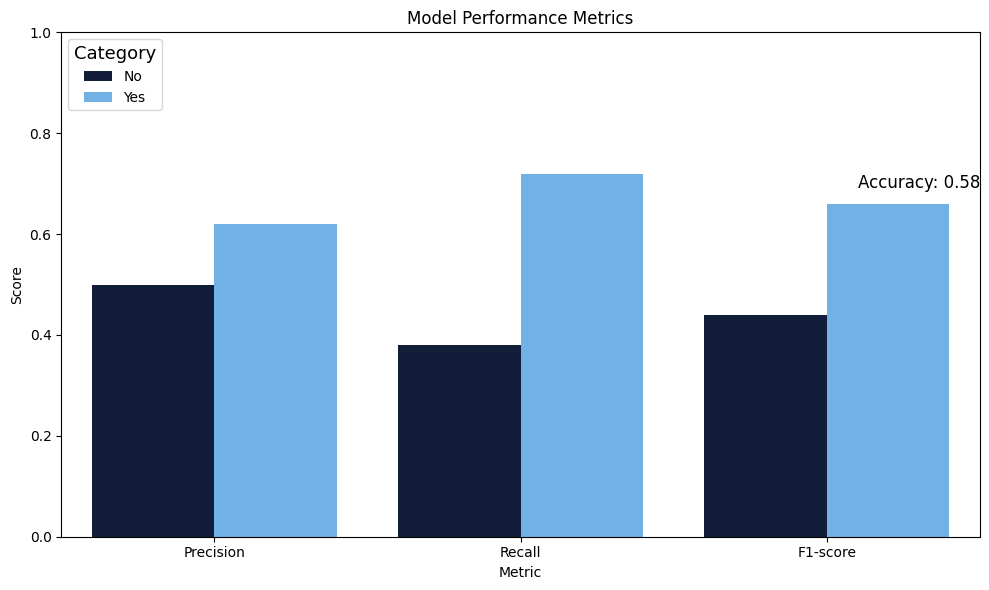

In [ ]:
# Custom color palette
custom_colors = ['#0c1b3f',  # Deep Sea Blue
                 '#5fb3f9',  # Sky Blue
                 '#86f3fa',  # Ice Blue
                 '#4b8bb3',  # Steel Blue
                 '#2d60df',  # Midnight Blue
                 '#eaeaea']  # Soft Silver

# Scores from the classification report
scores = {
    'Precision': {'No': 0.50, 'Yes': 0.62},
    'Recall': {'No': 0.38, 'Yes': 0.72},
    'F1-score': {'No': 0.44, 'Yes': 0.66}
}

# Convert scores to a format suitable for seaborn bar plot
data = []
for metric, values in scores.items():
    for category, score in values.items():
        data.append({'Metric': metric, 'Category': category, 'Score': score})

# Convert the list of dictionaries to a DataFrame
data_df = pd.DataFrame(data)

# Accuracy score from your model
accuracy = 0.5794486215538847

# Creating the plot
plt.figure(figsize=(10, 6))

# Setting the custom color palette
sns.set_palette(custom_colors)

# Creating a bar plot using the DataFrame
sns.barplot(x="Metric", y="Score", hue="Category", data=data_df)

# Get the current y-axis limit to adjust text annotation dynamically
y_lim = plt.gca().get_ylim()
y_text_annotation = y_lim[1] * 0.95

# Adding the accuracy score as a text annotation on the plot at top right
plt.text(2.5, y_text_annotation, f'Accuracy: {accuracy:.2f}', fontsize=12, ha='right', va='top', color='black')

plt.title('Model Performance Metrics')
plt.ylim(0, 1)  # Setting y-axis limit for better visualization of metrics
plt.ylabel('Score')
plt.xlabel('Metric')

plt.legend(title='Category', title_fontsize='13', loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate the probabilities of the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.5874666370106761


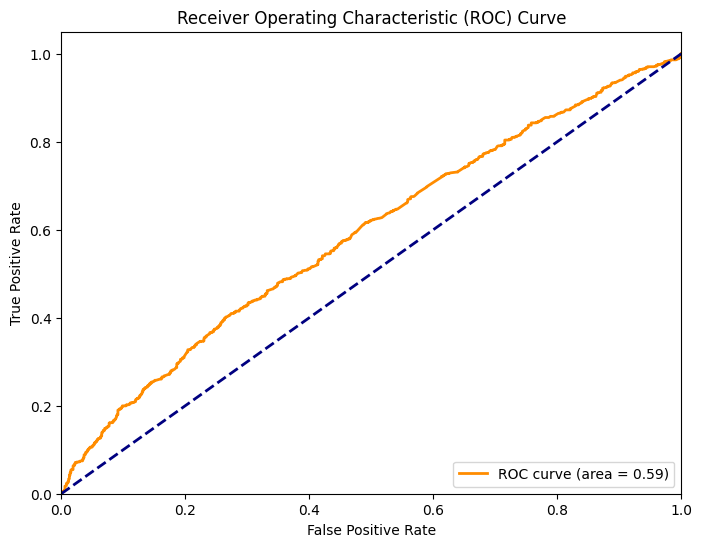

In [ ]:
# Calculate the probabilities of the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='Yes')  # Adjust pos_label based on your positive class

# Calculate the AUC (Area under the ROC Curve)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[324 519]
 [320 832]]


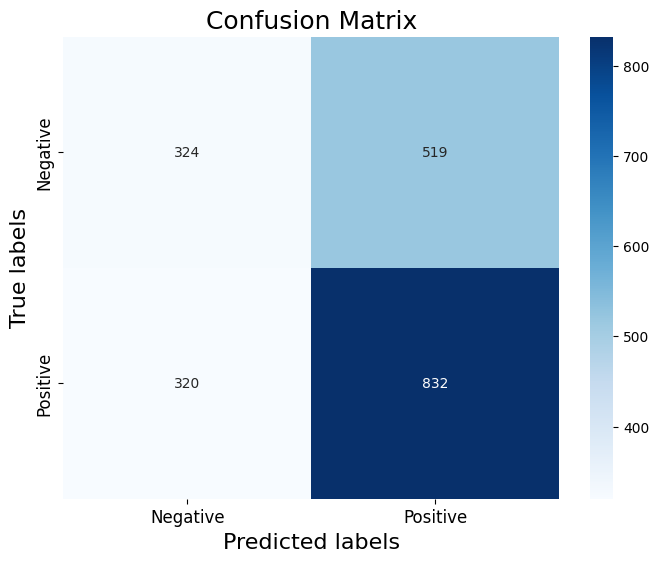

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming y_test and y_pred are defined from your model's predictions
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)

# Labels, title and ticks
label_font = {'size':'16'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);
ax.set_title('Confusion Matrix', fontdict={'size':'18'});
ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

plt.show()


In [ ]:
classifier = model.named_steps['classifier']

# Get the names of the features after preprocessing
feature_names = model.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out(input_features=categorical_features)

# Get the coefficients of the model
coefficients = classifier.coef_[0]

# Create a DataFrame for better visualization
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the coefficients by their absolute value to see which ones have more weight
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)

                       Feature  Coefficient
1368       city_West Hollywood    -1.287427
52              city_Asheville    -1.201570
1191  city_South San Francisco     1.158168
1066               city_Reston     1.129906
349              city_Edmonton     1.126597
...                        ...          ...
1577     state_Gullbringusysla    -0.002175
229           city_Chattanooga    -0.001736
1801           state_Sao Paulo     0.001301
1842               state_Texas     0.000932
650                city_Kuopio     0.000392

[2023 rows x 2 columns]


In [ ]:
# Prepare the data for SHAP (this requires X_train to be preprocessed)
X_train_preprocessed = model.named_steps['preprocessor'].transform(X_train)

# Initialize the SHAP explainer
explainer = shap.Explainer(model.named_steps['classifier'], X_train_preprocessed)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_preprocessed)


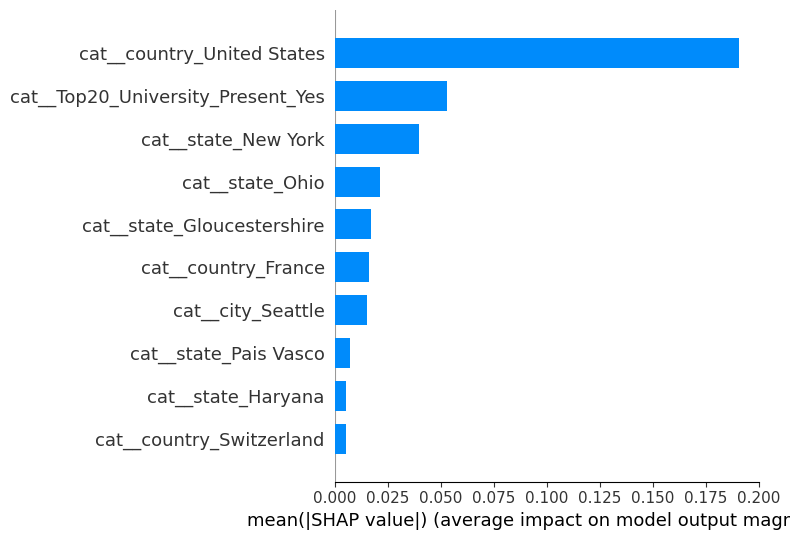

In [ ]:
# Compute the mean absolute SHAP values for each feature and keep only positive values
mean_shap_values_positive = np.maximum(np.mean(shap_values, axis=0), 0)

# Sort the features by their mean absolute SHAP values in descending order
sorted_indices = np.argsort(-mean_shap_values_positive)

# Select the top N features with the most positive impact
top_n = 10  # Adjust this to select the number of top features you want to display
top_indices = sorted_indices[:top_n]

# Create a summary plot with only the top positive impacting features
shap.summary_plot(shap_values[:, top_indices], X_train_preprocessed[:, top_indices],
                  feature_names=np.array(preprocessor.get_feature_names_out())[top_indices],
                  plot_type="bar")


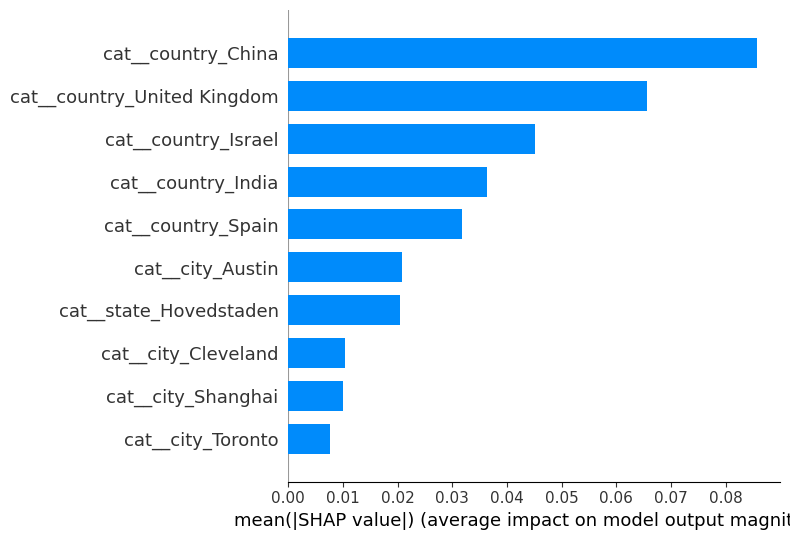

In [ ]:
# Compute the mean SHAP values for each feature and keep only negative values
mean_shap_values_negative = np.minimum(np.mean(shap_values, axis=0), 0)

# Sort the features by their mean SHAP values in ascending order to get the most negative impact
sorted_indices = np.argsort(mean_shap_values_negative)

# Select the top N features with the most negative impact
top_n = 10  # Adjust this to select the number of top features you want to display
top_indices = sorted_indices[:top_n]

# Create a summary plot with only the top negative impacting features
shap.summary_plot(shap_values[:, top_indices], X_train_preprocessed[:, top_indices], feature_names=np.array(preprocessor.get_feature_names_out())[top_indices], plot_type="bar")

### **OTHER MODELS RESULTS**


In [ ]:
# Selecting features and target
X = final_df[['Positive', 'Negative', 'Neutral', 'city', 'state', 'country', 'Top20_University_Present',
              'Technology', 'Health & Wellness', 'Finance', 'Education', 'Manufacturing', 'Miscellaneous']]
y = final_df['ADVANCED_STAGE']

# Encoding the target variable if it's categorical
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Since we have categorical features, let's use a simple approach to convert them to numeric
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Make sure both training and test set have the same columns after encoding
X_train, X_test = X_train.align(X_test, join='inner', axis=1)  # This ensures both have the same columns

# Example model: Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
rf_predictions = rf_clf.predict(X_test)



In [ ]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_predictions)}")


#GRADIENT BOOSTING MACHINES
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)
gbm_predictions = gbm_model.predict(X_test)
print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, gbm_predictions)}")


#KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
print(f"KNN Accuracy: {accuracy_score(y_test, knn_predictions)}")

Random Forest Accuracy: 0.5568922305764411
Gradient Boosting Accuracy: 0.5759398496240602
KNN Accuracy: 0.5614035087719298


**ACCURACY COMPARISON**

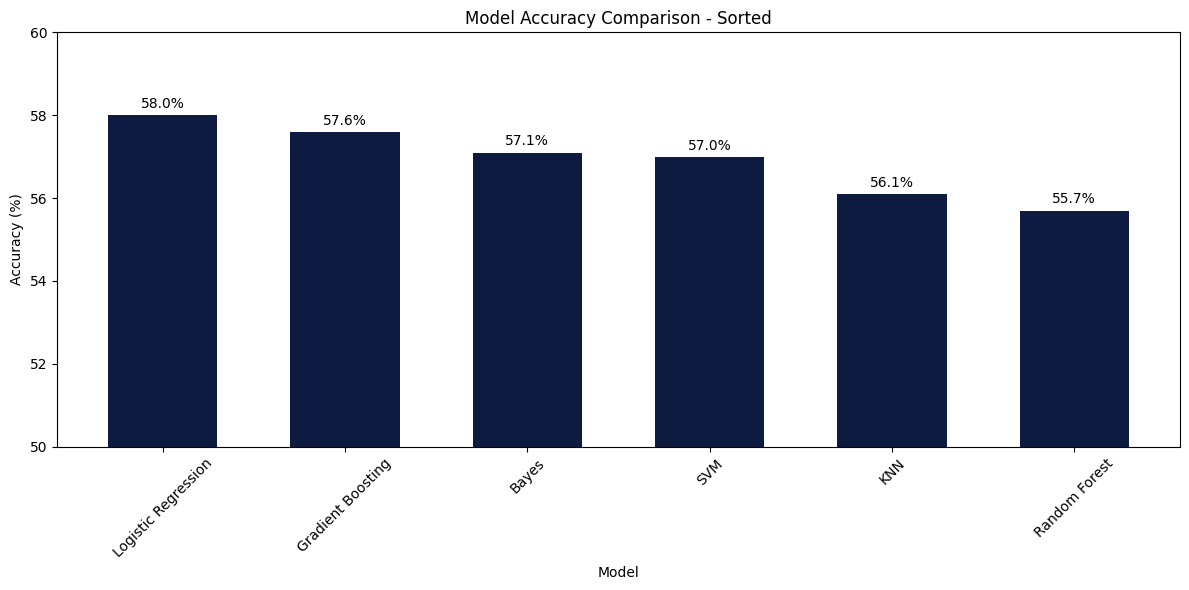

In [ ]:
# Data for the models and their accuracy, unsorted
models = ['SVM', 'Logistic Regression', 'Gradient Boosting', 'Random Forest', 'Bayes', 'KNN']
accuracy = [57.0, 58.0, 57.6, 55.7, 57.1, 56.1]

# Combine models and accuracy into a list of tuples and sort by accuracy
model_accuracy_pairs = sorted(zip(models, accuracy), key=lambda x: x[1], reverse=True)

# Unzip the sorted pairs back into models and accuracy lists
sorted_models, sorted_accuracy = zip(*model_accuracy_pairs)

# Setting up the figure and axes for the bar graph
plt.figure(figsize=(12, 6))  # Adjust figure size for readability
bar_width = 0.6  # Increased bar width for less space between bars
bars = plt.bar(sorted_models, sorted_accuracy, color='#0c1b3f', width=bar_width)
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison - Sorted')
plt.xticks(rotation=45)  # Rotate the x-axis labels for readability
plt.ylim(50, 60)  # Extend y-axis limit for displaying values on top

# Loop through each bar to place the accuracy value on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f"{yval}%", ha='center', va='bottom')

# Adjust layout to ensure nothing overlaps and remove grid lines
plt.grid(False)
plt.tight_layout()

# **VISUALIZATIONS**

In [ ]:
# Create DF to use for visualizations
final_df_for_analysis = final_df
final_df_for_analysis['Outcome'] = final_df['EXITED_ON'].apply(lambda x: 'Success' if isinstance(x, pd.Timestamp) else 'Non success')
final_df_for_analysis['Closed_Status'] = final_df['CLOSED_ON'].apply(lambda x: 'Closed' if isinstance(x, pd.Timestamp) else 'Not Closed')


print(final_df_for_analysis)


                  COMPANY_ID      FUNDING_TYPE ANNOUNCED_DATE  \
0                 %C3%81eron          Series A     2014-08-01   
1                 %C4%93dn-2  Convertible Note     2016-02-26   
2      -the-one-of-them-inc-          Series A     2011-10-03   
3                     1-page              Seed     2012-04-01   
4                    10alike              Seed     2013-01-01   
...                      ...               ...            ...   
21988               playmobs               NaN            NaT   
21989            identimob-2               NaN            NaT   
21991    envision-blue-green               NaN            NaT   
21992                  jiuge               NaN            NaT   
21993       shipping-company               NaN            NaT   

          INVESTMENT_STAGE  MONEY_RAISED ADVANCED_STAGE  Positive  Negative  \
0      Early Stage Venture             —            Yes         0         0   
1                        —      $100,000            Yes      

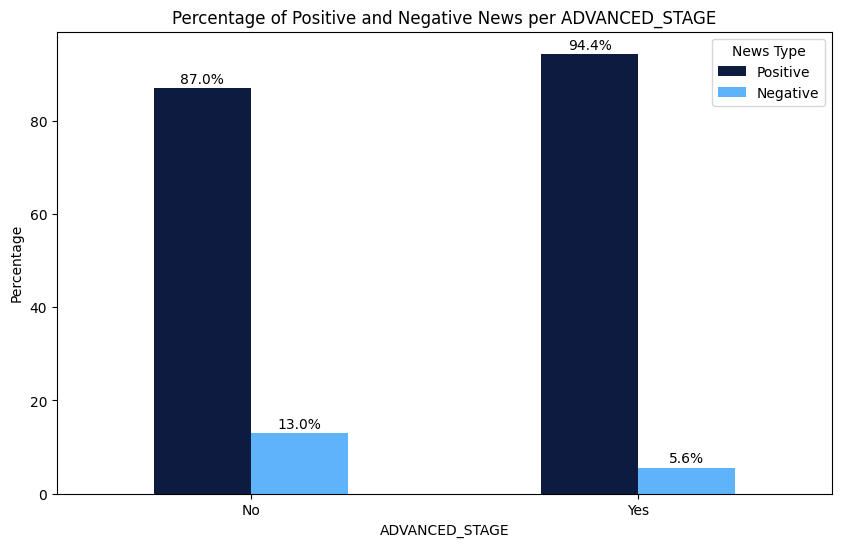

In [ ]:
# Group by ADVANCED_STAGE and sum the news counts
news_counts = final_df_for_analysis.groupby('ADVANCED_STAGE')[['Positive', 'Negative']].sum()

# Calculate percentages
total_news = news_counts.sum(axis=1)
news_percentages = news_counts.div(total_news, axis=0) * 100

# Plotting
ax = news_percentages.plot(kind='bar', figsize=(10, 6))
plt.title('Percentage of Positive and Negative News per ADVANCED_STAGE')
plt.xlabel('ADVANCED_STAGE')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='News Type')

# Annotate percentages
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height + 1), ha='center')

plt.show()

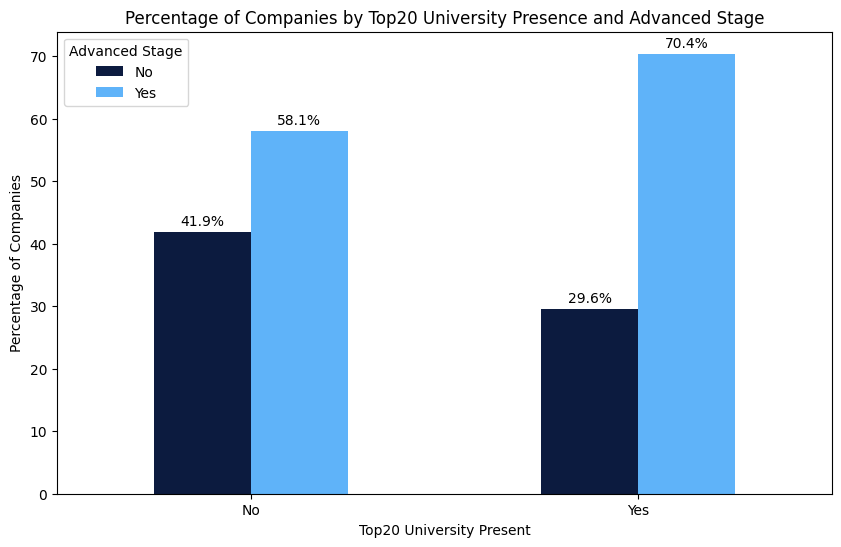

In [ ]:
# Group by Top20_University_Present and ADVANCED_STAGE, and count the number of companies
company_counts = final_df_for_analysis.groupby(['Top20_University_Present', 'ADVANCED_STAGE']).size().unstack(fill_value=0)

# Calculate percentages
company_percentages = company_counts.div(company_counts.sum(axis=1), axis=0) * 100

# Plotting
ax = company_percentages.plot(kind='bar', figsize=(10, 6))
plt.title('Percentage of Companies by Top20 University Presence and Advanced Stage')
plt.xlabel('Top20 University Present')
plt.ylabel('Percentage of Companies')
plt.xticks(rotation=0)
plt.legend(title='Advanced Stage')

# Annotate percentages
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height + 1), ha='center')

plt.show()